## Test of different radiative models in capturing the NDSI / FSC observed dynamics

This experiment also allows us to understand the uncertainty associated to the NDSI-FSC coversion 

We consider a radiative model for retrieving fractional snow cover from observations:
- One pixel is composed by soil, snow, and vegetation in a variable fraction (endmembers).
- We consider different simple radiative models that express the total reflectance of that pixel as a combination of the endmembers reflectances
- We compute the NDSI generated by these models for an ensemble of possibile vegetation, soil, snow reflectances
- We plot the NDSI vs FSC curves for all the possible reflectance combinations and compare it to litterature NDSI based approaches

The set of vegetationand soil reflectances are only quicly set and need to be refined

In other words, we simulate (simple) radiative forward models between FSC and NDSI. We compare these simulations to the retrieval  NDSI -> FSC approaches, formulated without assuming any forward model but fitting the observations.
This way e can:
- Have an idea of the uncertainty of NDSI based approaches, depending on the forward model chosen 
- Are these forward models adapted to describe the observations, knowing that the NDSI-FSC fits have been obtained fitting observations to ground truth?

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.lines import Line2D

In [98]:
# US vs EU
def salomonson_appel(ndsi):
    return 1.45*ndsi - 0.01

def gascoin(ndsi, f_veg):
    f_snow_toc = 0.5 * np.tanh(2.65*ndsi - 1.42) + 0.5
    return np.minimum(1, f_snow_toc/(1-f_veg))

In [99]:
# Generate Salomonson and Appel reference line 
ndsi_ref = np.linspace(0,1,1000)
fsc_salomonson = salomonson_appel(ndsi_ref)


In [100]:
# inputs: SHOULD BE REFINED
#[1] Metsämäki, Sari, Olli-Pekka Mattila, Jouni Pulliainen, Kirsikka Niemi, Kari Luojus, et Kristin Böttcher. « An optical reflectance model-based method for fractional snow cover mapping applicable to continental scale ». Remote Sensing of Environment 123 (1 août 2012): 508‑21. https://doi.org/10.1016/j.rse.2012.04.010.

f_veg = np.array([0,0.25,0.5,0.75])             

rho_snow_g = np.linspace(0.65,0.9,3)            # 0.65 in [1]
rho_veg_g = np.linspace(0.02,0.14,3)            # 0.08 in [1]
rho_soil_g = np.linspace(0.04,0.16,3)           # 0.10 in [1]

rho_snow_swir = 0.001
rho_veg_swir = np.linspace(0.05,0.2,3)          # Quickly estimated by looking at one VIIRS L1B image
rho_soil_swir = np.linspace(0.05,0.3,3)         # Quickly estimated by looking at one VIIRS L1B image

possible_combinations = [comb for comb in itertools.product(rho_soil_g, rho_veg_g, rho_soil_swir, rho_snow_g, rho_veg_swir)]

In [101]:
def compute_test_ndsi_lin( f_veg: float, 
                          rho_snow_g: float=0.9, 
                          rho_snow_swir: float=0, 
                          rho_veg_g:float=0.3, 
                          rho_veg_swir:float=0.3, 
                          rho_soil_g:float=0.3, 
                          rho_soil_swir:float=0.5):
    """Linear mix model:
       Total reflectance as a linear combination of endmembers reflectances weighted by their fraction.
       See publications on MODSCAG
    """
    # Generate snow fractions
    f_snow = np.linspace(0,1,100)
    f_soil = 1 - f_veg - f_snow
    rho_g = rho_snow_g * f_snow + rho_veg_g * f_veg + rho_soil_g * f_soil
    rho_swir = rho_snow_swir * f_snow + rho_veg_swir * f_veg + rho_soil_swir * f_soil
    return f_snow, (rho_g - rho_swir) / (rho_g + rho_swir)

def compute_test_ndsi_lin_toc( f_veg: float, 
                              rho_snow_g: float=0.9, 
                              rho_snow_swir: float=0, 
                              rho_veg_g:float=0.3, 
                              rho_veg_swir:float=0.3, 
                              rho_soil_g:float=0.3, 
                              rho_soil_swir:float=0.5):
    """Linear mix model separating top of canopy and on ground snow.
       We assume that all snow is on ground. 
       The snow on the top of the canopy is estimated by linearly reducing the snow on ground with the fraction of vegetation
       The inverse correction is in use for Sentinel-2 (Gascoin et al. 2021, Muhuri et al. 2021 )
    """
    # Generate snow fractions
    f_snow_og = np.linspace(0,1,100)
    f_soil = 1 - f_veg - f_snow_og
    f_snow_toc = f_snow_og*(1-f_veg)
    rho_g = rho_snow_g * f_snow_toc + rho_veg_g * f_veg + rho_soil_g * f_soil
    rho_swir = rho_snow_swir * f_snow_toc + rho_veg_swir * f_veg + rho_soil_swir * f_soil
    return f_snow_og, (rho_g - rho_swir) / (rho_g + rho_swir)


def compute_test_ndsi_scamod(rho_wet_snow_g: float=0.9, 
                             rho_wet_snow_swir: float=0, 
                             rho_veg_g:float=0.3, 
                             rho_veg_swir:float=0.3, 
                             rho_soil_g:float=0.3, 
                             rho_soil_swir:float=0.5,
                             t2_g: float=0.5,
                             t2_swir:float=0.5
                             ):
    """SCAmod algorithm (Metsämäki et al. 2012).
    In use for VIIRS Northern emisphere CLMS.
    A transmittivity term t2 characterizes the scattering in the forest.
    This transmittivity term has to be estimated spatially.
    """
    # Generate snow fractions
    f_snow = np.linspace(0,1,100)
    f_soil = 1 - f_snow
    rho_g = rho_veg_g * (1-t2_g)  + t2_g*(f_snow*rho_wet_snow_g + f_soil*rho_soil_g)
    rho_swir = rho_veg_swir * (1-t2_swir)  + t2_swir*(f_snow*rho_wet_snow_swir + f_soil*rho_soil_swir)
    return f_snow, (rho_g - rho_swir) / (rho_g + rho_swir)

Text(0.5, 1.0, 'Linear mixing model')

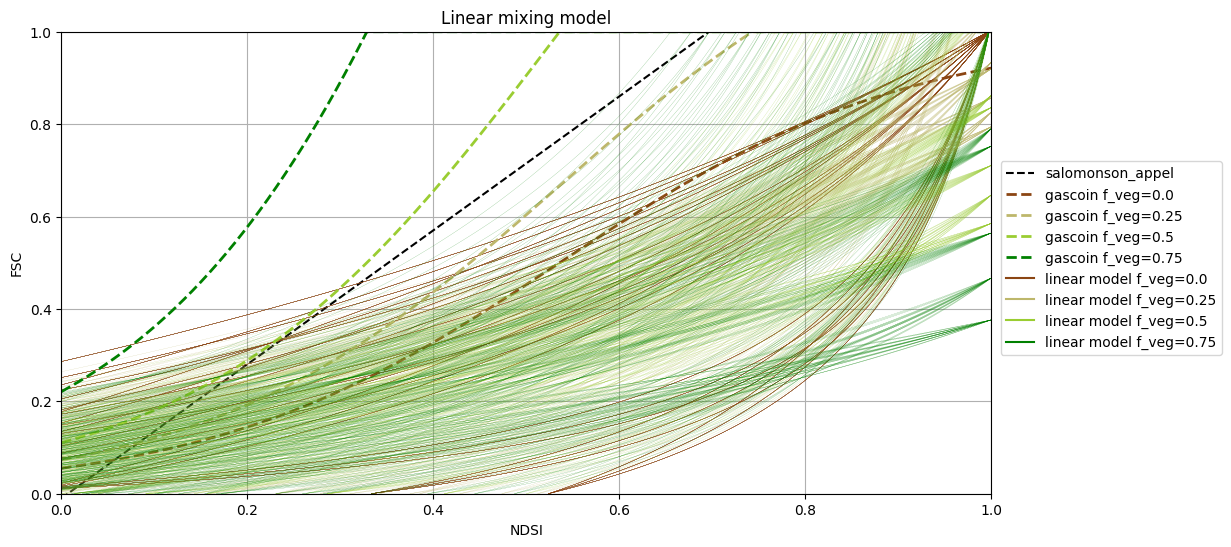

In [102]:
fig, ax = plt.subplots(figsize=(12,6))
colors = ['saddlebrown', 'darkkhaki','yellowgreen', 'green']
ax.plot(ndsi_ref, fsc_salomonson, '--k',label='salomonson_appel')
manual_legends=[]
for test_f_veg, color in zip(f_veg, colors):
    # S2 regression with true cover density correction
    fsc_gascoin = gascoin(ndsi_ref, test_f_veg)
    ax.plot(ndsi_ref, fsc_gascoin,'--',linewidth=2,color=color, label=f'gascoin f_veg={test_f_veg}')
    for comb in possible_combinations:
        test_rho_soil_g, test_rho_veg_g, test_rho_soil_swir, test_rho_snow_g, test_rho_veg_swir  = comb
        f_snow_test, ndsi_test = compute_test_ndsi_lin(f_veg=test_f_veg, 
                                                    rho_soil_g=test_rho_soil_g,
                                                    rho_soil_swir=test_rho_soil_swir, 
                                                    rho_snow_g=test_rho_snow_g, 
                                                    rho_snow_swir=rho_snow_swir,
                                                    rho_veg_swir=test_rho_veg_swir,
                                                    rho_veg_g=test_rho_veg_g)
        ax.plot(ndsi_test, f_snow_test, linewidth=0.1, color=color)


    manual_legends.append(Line2D([0], [0], label=f'linear model f_veg={test_f_veg}', color=color))

ax.set_xlabel('NDSI')
ax.set_ylabel('FSC')
ax.grid(True)
ax.set_ylim(0,1)
ax.set_xlim(0,1)
handles, labels = ax.get_legend_handles_labels()
handles.extend(manual_legends)
ax.legend(handles=handles,loc=(1.01,0.3))
ax.set_title("Linear mixing model")

The linear mixing model looks uncapable of capturing the observed NDSI behaviour with these settings:
- The curves for no vegetation do not really seem to capture the "sigmoid" behaviour commonly observed in NDSI vs FSC scatter plots (this is the case for also the other models)
- As the vegetation increases, the curves do not really move towards Salomonson and Appel nor Gascoin's fits.
- For high vegetation cover, we have a series of "unrealistic" simulations: FSC <1 for NDSI -> 1 in the forest...it looks not really logic

Text(0.5, 1.0, 'Linear mixing model corrected for tree cover density')

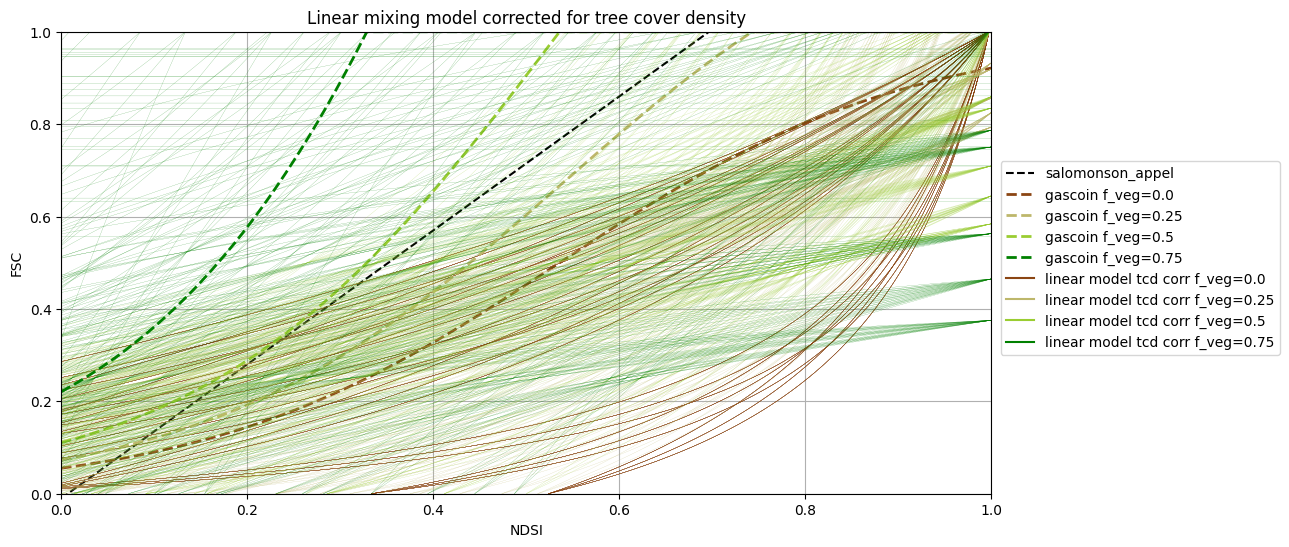

In [103]:
fig, ax = plt.subplots(figsize=(12,6))
colors = ['saddlebrown', 'darkkhaki','yellowgreen', 'green']
ax.plot(ndsi_ref, fsc_salomonson, '--k',label='salomonson_appel')
manual_legends=[]
for test_f_veg, color in zip(f_veg, colors):
    # S2 regression with true cover density correction
    fsc_gascoin = gascoin(ndsi_ref, test_f_veg)
    ax.plot(ndsi_ref, fsc_gascoin,'--',linewidth=2,color=color, label=f'gascoin f_veg={test_f_veg}')
    for comb in possible_combinations:
        test_rho_soil_g, test_rho_veg_g, test_rho_soil_swir, test_rho_snow_g, test_rho_veg_swir  = comb

        f_snow_test, ndsi_test = compute_test_ndsi_lin_toc(f_veg=test_f_veg, 
                                                    rho_soil_g=test_rho_soil_g,
                                                    rho_soil_swir=test_rho_soil_swir, 
                                                    rho_snow_g=test_rho_snow_g, 
                                                    rho_snow_swir=rho_snow_swir,
                                                    rho_veg_swir=test_rho_veg_swir,
                                                    rho_veg_g=test_rho_veg_g)
        ax.plot(ndsi_test, f_snow_test, linewidth=0.1, color=color)

    manual_legends.append(Line2D([0], [0], label=f'linear model tcd corr f_veg={test_f_veg}', color=color))

ax.set_xlabel('NDSI')
ax.set_ylabel('FSC')
ax.grid(True)
ax.set_ylim(0,1)
ax.set_xlim(0,1)
handles, labels = ax.get_legend_handles_labels()
handles.extend(manual_legends)
ax.legend(handles=handles,loc=(1.01,0.3))
ax.set_title("Linear mixing model corrected for tree cover density")

Applying a tree cover correction seems to enhance the linear mixing method, going to cover the upper left part of the NDSI-FSC plot commonly observed in forested areas. However, the errors in case of high vegetation cover.
The unrealistic relations for high f_veg are still there.

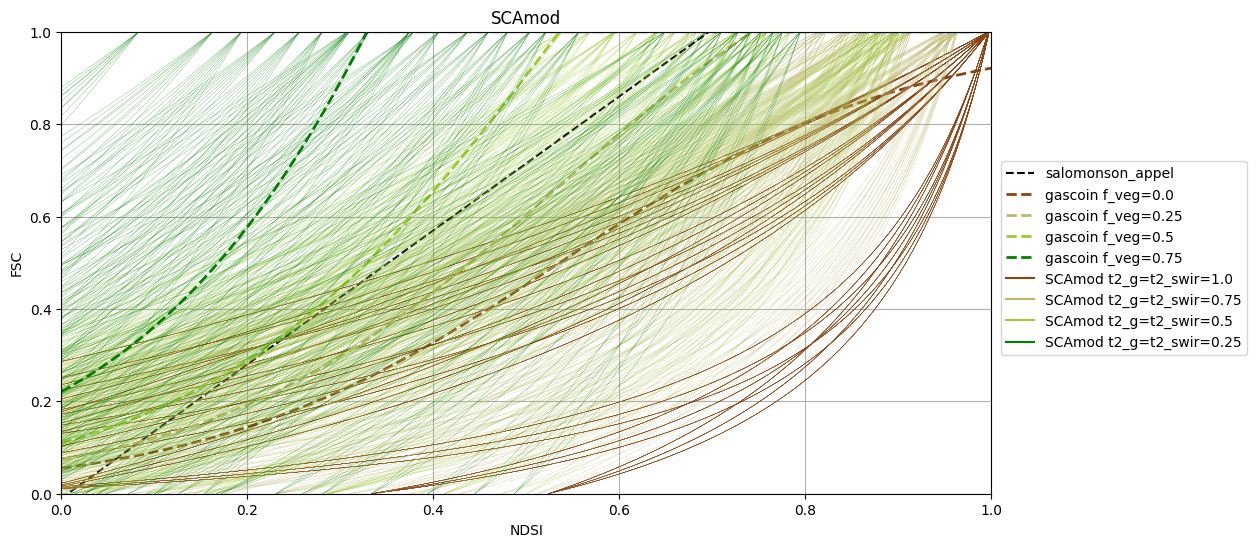

In [104]:
fig, ax = plt.subplots(figsize=(12,6))
colors = ['saddlebrown', 'darkkhaki','yellowgreen', 'green']
ax.plot(ndsi_ref, fsc_salomonson, '--k',label='salomonson_appel')
manual_legends=[]
for test_f_veg, color in zip(f_veg, colors):
    # S2 regression with true cover density correction
    fsc_gascoin = gascoin(ndsi_ref, test_f_veg)
    ax.plot(ndsi_ref, fsc_gascoin,'--',linewidth=2,color=color, label=f'gascoin f_veg={test_f_veg}')
    for comb in possible_combinations:
        test_rho_soil_g, test_rho_veg_g, test_rho_soil_swir, test_rho_snow_g, test_rho_veg_swir  = comb

        # Transmittivity is brutally imposed equal to the non-forest fraction

        f_snow_test, ndsi_test = compute_test_ndsi_scamod(rho_soil_g=test_rho_soil_g,
                                                        rho_soil_swir=test_rho_soil_swir, 
                                                        rho_wet_snow_g=test_rho_snow_g, 
                                                        rho_wet_snow_swir=rho_snow_swir,
                                                        rho_veg_swir=test_rho_veg_swir,
                                                        rho_veg_g=test_rho_veg_g,
                                                        t2_g=1-test_f_veg,
                                                        t2_swir=1-test_f_veg)
        ax.plot(ndsi_test, f_snow_test, linewidth=0.15, color=color)
    manual_legends.append(Line2D([0], [0], label=f'SCAmod t2_g=t2_swir={1-test_f_veg}', color=color))

    ax.set_xlabel('NDSI')
    ax.set_ylabel('FSC')
    ax.grid(True)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(manual_legends)
    ax.legend(handles=handles,loc=(1.01,0.3))
    ax.set_title("SCAmod")
   

SCAmod forward model has a more stable dynamics in the forest. We get rid of unrealistic simulations at high f_veg.

### Conclusions

- The spectral unmixing methods are based on a linear mixing forward model. However, a linear unmixing forward model doesn't look to well describe the observed radiated light (NDSI) on a mixed pixel. Anyways, these methods use more bands and optimally look for the linear combination so isn't really the same thing.
- Salomonson and Appel regression might be a compromise between "no vegetation" and "full vegetation", as it limits the max error in both cases, but the RMSE introduced is generally high
- Introducing a correction for tree cover in the form of linear scaling or transmissivity might better desribe the transmitted light (and hence the observations).
- The NDSI approach for retrieving subpixel FSC in canopy might be a chimera...the sensitivity of NDSI to vegetation, soil is so high that for any regression we might fit the residual is still super high.